In [1]:
import os
import re
import subprocess
import pickle
from collections import Counter
import chardet

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from nltk.corpus import stopwords
from collections import namedtuple
from sklearn.naive_bayes import GaussianNB
from nltk import NaiveBayesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
import os
import collections
import smart_open
import random

from sklearn.model_selection import train_test_split

TopicProcess = namedtuple('TopicProcess', ['model', 'vectorizer', 'training_vectors'])

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

plt.style.use("seaborn")
%matplotlib inline

Defining stopwords

In [2]:
stop = stopwords.words('spanish')
stop += ['.', ',', '(', ')', "'", '"', "-", "ja"]
stop = set(stop)

Function to draw the confusion matrix for two authors (Baroja and Galdós)

In [3]:
def conf_plot_2(y, y_pred):
    trees_confusion = confusion_matrix(y, y_pred)
    plt.figure(dpi=180)
    sns.heatmap(trees_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
               xticklabels=["Galdós","Baroja"],
               yticklabels=["Galdós","Baroja"], annot_kws={"size": 20});
    plt.xlabel('prediction')
    plt.ylabel('actual');
    
    


Function to draw the confusion matrix for all authors

In [4]:
def conf_plot_all(y, y_pred):
    trees_confusion = confusion_matrix(y, y_pred)
    plt.figure(dpi=180)
    sns.heatmap(trees_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
               xticklabels=["Galdós","Bazán","Valera", "Clarín", "Unamuno", "Valle-Inclán", "Blasco Ibáñez","Baroja"],
               yticklabels=["Galdós","Bazán","Valera", "Clarín", "Unamuno", "Valle-Inclán", "Blasco Ibáñez","Baroja"], annot_kws={"size": 10} );
    plt.xlabel('prediction')
    plt.ylabel('actual');

Function to carry out grid search with cross validation and print train/test accuracies and other useful parameters.

In [5]:
def grid_estimator(estimator, param_grid, X_train_sca, y_train, X_test_sca, y_test, cv=5, multiclass = False):
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, n_jobs=1)
    grid.fit(X_train_sca, y_train)
    print("Accuracy training: " + str(grid.best_score_))
    y_pred = grid.predict(X_test_sca)
    print("Accuracy test: " + str(accuracy_score(y_pred,y_test)))
    if not multiclass:
        print("Recall test: " + str(recall_score(y_pred,y_test)))
        print("Precision test: " + str(precision_score(y_pred,y_test)))
        print("F1 score test: " + str(f1_score(y_pred,y_test)))
    print(grid.best_estimator_)

Function to show topics for the vectorized fragments 

In [6]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

Incorporating vectorization and dimensionality reduction in a single function. The output is a named tuple with model vectorizer and training method.

In [7]:
def vectorization_reduction(data, stop, vec, dim_red, n_comp, ngram_min, ngram_max, max_freq): 
    count_vectorizer = CountVectorizer(ngram_range=(ngram_min, ngram_max),  
                                       stop_words=stop, 
                                       token_pattern="\\b[a-z][a-z]+\\b",
                                       lowercase=True,
                                       max_df = max_freq)
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(ngram_min, ngram_max),  
                                       stop_words=stop, 
                                       token_pattern="\\b[a-z][a-z]+\\b",
                                       lowercase=True,
                                       max_df = max_freq)
    cv_data = count_vectorizer.fit_transform(data)
    tfidf_data = tfidf_vectorizer.fit_transform(data)
    if vec=="count" and dim_red=="LSA":
        lsa_cv = TruncatedSVD(n_components=n_comp)
        lsa_cv_data = lsa_cv.fit_transform(cv_data)
        return TopicProcess(model=lsa_cv, vectorizer=count_vectorizer, training_vectors=lsa_cv_data)
    if vec=="count" and dim_red=="NMF":
        nmf_cv = NMF(n_components=n_comp)
        nmf_cv_data = nmf_cv.fit_transform(cv_data)
        return TopicProcess(model=nmf_cv, vectorizer=count_vectorizer, training_vectors=nmf_cv_data)
    if vec=="tfidf" and dim_red=="LSA":
        lsa_tfidf = TruncatedSVD(n_components=n_comp)
        lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)
        return TopicProcess(model=lsa_tfidf, vectorizer=tfidf_vectorizer, training_vectors=lsa_tfidf_data)

Function to check how many times a given sentence appears in each book.

In [10]:
def find_words(sentence):
    ocurrences = []
    for book in books:
        text_book= all_books[book]   
        for fragment in text_book:
            if sentence in fragment:
                ocurrences.append(book)
    return Counter(ocurrences)

### Load data from all_books.pkl

In [8]:
with open('all_books.pkl', 'rb') as file: 
    all_books = pickle.load(file)

In [9]:
books = [book for book in all_books.keys()]

In [11]:
find_words("socarrao")

Counter({'Vicente_Blasco_Ibáñez_La_barca_abandonada': 9})

Labeling authors

In [12]:
def extract_all(author_list, all_books):
    books_author = []
    author_data = []
    y_author = []
    books = [book for book in all_books.keys()]
    for label, author in enumerate(author_list):
        books_author =[]
        for book in books:
            if author in book:
                books_author.append(book)
        for book in books_author:
            entries_book= all_books[book]
            for entry in entries_book:
                author_data.append(entry)
                y_author.append(label)
    return author_data, y_author

In [13]:
all_authors = ["Benito_Pérez_Galdos","Emilia_Pardo_Bazán",  "Juan_Valera", "Leopoldo_Alas_Clarín", 
               "Miguel_de_Unamuno", "Ramón_del_Valle_Inclán", "Vicente_Blasco_Ibáñez", "Pío_Baroja"]

In [14]:
all_authors_data, y_author = extract_all(all_authors, all_books)

Train/test split for set with all authors

In [15]:
all_train, all_test, y_train, y_test = train_test_split(all_authors_data, y_author, test_size=.20,stratify=y_author)

In [16]:
len(all_authors_data)

45961

In [17]:
Counter(y_author)

Counter({0: 20566,
         1: 6765,
         2: 906,
         3: 2591,
         4: 1584,
         5: 1612,
         6: 567,
         7: 11370})

Function to extract some authors.

In [18]:
def extract_author(all_data, y_data, label_authors):
    data_selected = []
    labels_selected = []
    for label, fragment in zip(y_data, all_data):
        if label in label_authors:
            data_selected.append(fragment)
            labels_selected.append(label)
    return data_selected, labels_selected

In [19]:
selected_data, y_selected = extract_author(all_authors_data, y_author, [0,7])
len(selected_data)

31936

In [20]:
y_selected = [1 if label==7 else 0 for label in y_selected]

In [21]:
Counter(y_selected)

Counter({0: 20566, 1: 11370})

Train/test split for set with the two authors with the majority of fragments (31936 out of 45961)

In [22]:
selected_train, selected_test, y_selected_train, y_selected_test = train_test_split(selected_data, y_selected, test_size=.20,stratify=y_selected)

### Vectorizing the data and extracting topics for all authors

In [19]:
len(all_authors_data)

45961

Using vectorization with 10 topics

In [82]:
process_lsa_tfidf_selected = vectorization_reduction(selected_data, stop, vec="tfidf", dim_red="LSA", n_comp=10, ngram_min=1, ngram_max=3, max_freq=0.2)

In [83]:
display_topics(process_lsa_tfidf_selected.model, process_lsa_tfidf_selected.vectorizer.get_feature_names(),10)


Topic  0
casa, pues, dos, tan, bien, hombre, ser, dios, ahora, mismo

Topic  1
manuel, casa, dos, aviraneta, don, calle, vidal, puerta, roberto, baronesa

Topic  2
aviraneta, don, eugenio, dos, pueblo, general, empecinado, don eugenio, san, hombres

Topic  3
conde, dolly, nell, aviraneta, don, cura, venancio, electra, lucrecia, gregoria

Topic  4
dos, conde, dolly, nell, tres, lucrecia, cura, dos tres, venancio, gregoria

Topic  5
casa, calle, conde, madre, padre, noche, gray, lord gray, dolly, lord

Topic  6
dos, pues, electra, pantoja, casa, evarista, don, ahora, urbano, don urbano

Topic  7
pues, aviraneta, casa, hombre, dos, puede, voy, dije, creo, ser

Topic  8
pues, electra, calle, franceses, lord, hacia, gray, lord gray, san, conde

Topic  9
aviraneta, ahora, vamos, electra, voy, puerta, ver, dije, hacia, repuso


In [84]:
process_lsa_tfidf_selected.training_vectors[0]

array([ 0.02028246,  0.00434359,  0.00386061, -0.00807671,  0.00527746,
       -0.00136317, -0.00775218, -0.00326574,  0.0075122 , -0.00184036])

Function for Gaussian Naive Bayes fit

In [28]:
def GNB(X, Y):
    GNB = GaussianNB()
    GNB.fit(X, Y)
    return GNB.score(X,Y)

#### Using Naive Bayes for classification for the two authors with highest number of books trying different vectorization methods

In [29]:
process_lsa_tfidf_selected = vectorization_reduction(selected_data, stop, vec="tfidf", dim_red="LSA", 
                                            n_comp=10, ngram_min=1, ngram_max=3, max_freq=0.2)
score = GNB(process_lsa_tfidf_selected.training_vectors, y_selected)
score

0.7910821643286573

In [30]:
process_lsa_count_selected = vectorization_reduction(selected_data, stop, vec="count", dim_red="LSA",
                                            n_comp=10, ngram_min=1, ngram_max=3, max_freq=0.2)
score = GNB(process_lsa_count_selected.training_vectors, y_selected)
score

0.5244238476953907

In [31]:
process_nmf_count_selected = vectorization_reduction(selected_data, stop, vec="count", dim_red="NMF",
                                            n_comp=10, ngram_min=1, ngram_max=3, max_freq=0.2)
score = GNB(process_nmf_count_selected.training_vectors, y_selected)
score

0.548816382765531

#### Using tfidf vectorization and LSA method for dimensionality reduction  
Different number of components and maximum frequencies for the dimensionality reduction are tried below. The accuracy of Gaussian Naive Bayes is used as indicator.

In [18]:
scores = []
for n_comp in range(5,26,5):
    for max_freq in np.arange(0.1,0.9,0.2):
        process_lsa_tfidf_selected = vectorization_reduction(selected_data, stop, vec="tfidf", dim_red="LSA", 
                                                    n_comp=n_comp, ngram_min=1, ngram_max=3, max_freq=max_freq)
        entry = [n_comp, max_freq, GNB(process_lsa_tfidf_selected.training_vectors, y_selected)]
        scores.append(entry)
        print(entry)
print(scores)

[5, 0.1, 0.7823459418837675]
[5, 0.30000000000000004, 0.7520040080160321]
[5, 0.5000000000000001, 0.7523484468937875]
[5, 0.7000000000000001, 0.7708855210420842]
[10, 0.1, 0.7846317635270541]
[10, 0.30000000000000004, 0.7461798597194389]
[10, 0.5000000000000001, 0.7504070641282565]
[10, 0.7000000000000001, 0.7504070641282565]
[15, 0.1, 0.8030748997995992]
[15, 0.30000000000000004, 0.7485909318637275]
[15, 0.5000000000000001, 0.7568261523046093]
[15, 0.7000000000000001, 0.7519100701402806]
[20, 0.1, 0.7952154308617234]
[20, 0.30000000000000004, 0.7508141282565131]
[20, 0.5000000000000001, 0.7543211422845691]
[20, 0.7000000000000001, 0.7550100200400801]
[25, 0.1, 0.7940255511022044]
[25, 0.30000000000000004, 0.7548221442885772]
[25, 0.5000000000000001, 0.7623371743486974]
[25, 0.7000000000000001, 0.7613038577154309]
[[5, 0.1, 0.7823459418837675], [5, 0.30000000000000004, 0.7520040080160321], [5, 0.5000000000000001, 0.7523484468937875], [5, 0.7000000000000001, 0.7708855210420842], [10, 0.

In [24]:
accus = [item[2] for item in scores]
max(accus)

0.8030748997995992

n_comp = 15; max_freq = 0.3 give the best results

#### Using Naive Bayes for classification of all authors

In [19]:
scores_all = []
for n_comp in range(5,26,5):
    for max_freq in np.arange(0.1,0.9,0.2):
        process_lsa_tfidf_all = vectorization_reduction(all_authors_data, stop, vec="tfidf", dim_red="LSA", 
                                                    n_comp=n_comp, ngram_min=1, ngram_max=3, max_freq=max_freq)
        entry = [n_comp, max_freq, GNB(process_lsa_tfidf_all.training_vectors, y_author)]
        scores_all.append(entry)
        print(entry)
print(scores_all)

[5, 0.1, 0.5075390004569091]
[5, 0.30000000000000004, 0.5263593046278366]
[5, 0.5000000000000001, 0.5206588194338678]
[5, 0.7000000000000001, 0.5201366375840386]
[10, 0.1, 0.35597571854398297]
[10, 0.30000000000000004, 0.39818541807184354]
[10, 0.5000000000000001, 0.40806335806444594]
[10, 0.7000000000000001, 0.4082374186810557]
[15, 0.1, 0.34551032397032266]
[15, 0.30000000000000004, 0.374948325754444]
[15, 0.5000000000000001, 0.3922238419529601]
[15, 0.7000000000000001, 0.4015360849415809]
[20, 0.1, 0.35168947585996824]
[20, 0.30000000000000004, 0.3822371140749766]
[20, 0.5000000000000001, 0.3958138421705359]
[20, 0.7000000000000001, 0.39252844803202713]
[25, 0.1, 0.3549095972672483]
[25, 0.30000000000000004, 0.3755792954896543]
[25, 0.5000000000000001, 0.37533996214181586]
[25, 0.7000000000000001, 0.3753834772959683]
[[5, 0.1, 0.5075390004569091], [5, 0.30000000000000004, 0.5263593046278366], [5, 0.5000000000000001, 0.5206588194338678], [5, 0.7000000000000001, 0.5201366375840386], [

In [ ]:
accus_all = [item[2] for item in scores_all]
max(accus_all)

n_comp = 5; max_freq = 0.3 has the best results

### Using doc2vectors for the vectorization

In [38]:
def transform_for_train_corpus(all_authors_data):
    train_corpus = []
    for index, fragment in enumerate(all_authors_data):
        train_corpus.append(gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(fragment), [index]))
    return train_corpus

In [39]:
def fit_doc2vec(train_corpus, vector_size=50, min_count=1, epochs=40):
    model = gensim.models.doc2vec.Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=epochs)
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    return model

In [ ]:
def train_n_fit(all_authors_data, y_author, model):
    training_vectors = []
    data_for_doc2vec = [[word for word in document.lower().split() if word not in stop] for document in all_authors_data]
    for fragment in data_for_doc2vec:
        training_vectors.append(model.infer_vector(fragment))
    score = GNB(training_vectors, y_author)
    return score

In [43]:
train_corpus = transform_for_train_corpus(all_authors_data)

In [44]:
model = fit_doc2vec(train_corpus, vector_size=50, min_count=1, epochs=40)

In [45]:
score = train_n_fit(all_authors_data, y_author, model)
score

0.44228802680533497

In [24]:
model.infer_vector(['ana', 'ozores', 'comió'])

array([ 0.49914163, -0.44113734,  0.06494018,  0.06041598, -0.11318292,
       -0.32962194,  0.24972932,  0.15756804,  0.19710712, -0.11033907,
       -0.30404103, -0.40385586, -0.18628687,  0.05007014,  0.01118725,
       -0.00110902,  0.05070319,  0.1340272 ,  0.07082558,  0.12938395,
        0.12206998, -0.34797257,  0.05153112, -0.29752082, -0.1570974 ,
        0.16492534,  0.01119012,  0.02569753, -0.32932946,  0.11117436,
       -0.09808011,  0.30893606, -0.23371974, -0.21927261,  0.48162466,
       -0.04992766,  0.28491783, -0.5036366 ,  0.4546197 ,  0.67449254,
       -0.0511196 ,  0.06997563, -0.43068683,  0.13664077, -0.07346426,
       -0.09099592, -0.34228063, -0.39741507,  0.04305704,  0.15899388],
      dtype=float32)

### Finding the best vectorization (Using Naive Bayes)

In [50]:
train_corpus = transform_for_train_corpus(all_authors_data)
scores_all = []
for vector_size in range(5,26,10):
    for epochs in [40]:
        for min_count in range(1,3):
            model = fit_doc2vec(train_corpus, vector_size=vector_size, min_count=min_count, epochs=epochs)
            score = train_n_fit(all_authors_data, y_author, model)
            entry = [vector_size, epochs, min_count, score]
            scores_all.append(entry)
            print(entry)    
print(scores_all)

[5, 40, 1, 0.44333239050499335]
[5, 40, 2, 0.4447901481690999]
[15, 40, 1, 0.44835839080959944]
[15, 40, 2, 0.44603033006244425]
[25, 40, 1, 0.4395248145166554]
[25, 40, 2, 0.44283196623224036]
[[5, 40, 1, 0.44333239050499335], [5, 40, 2, 0.4447901481690999], [15, 40, 1, 0.44835839080959944], [15, 40, 2, 0.44603033006244425], [25, 40, 1, 0.4395248145166554], [25, 40, 2, 0.44283196623224036]]


The accuracy obtained with GNB is much lower than for other vectorization methods

Trying the fit with more epochs in the doc2vec fit

In [31]:
scores_all = []
for vector_size in [5]:
    for epochs in range(40,141,20):
        for min_count in [1]:
            model = fit_doc2vec(train_corpus, vector_size=vector_size, min_count=min_count, epochs=epochs)
            score = train_n_fit(all_authors_data, y_author, model)
            entry = [vector_size, epochs, min_count, score]
            scores_all.append(entry)
            print(entry)    
print(scores_all)

[5, 40, 1, 0.5049063336306869]
[5, 60, 1, 0.5133917886904115]
[5, 80, 1, 0.5123256674136768]
[5, 100, 1, 0.522073061943822]
[5, 120, 1, 0.5218119710189073]
[5, 140, 1, 0.5263375470507604]
[[5, 40, 1, 0.5049063336306869], [5, 60, 1, 0.5133917886904115], [5, 80, 1, 0.5123256674136768], [5, 100, 1, 0.522073061943822], [5, 120, 1, 0.5218119710189073], [5, 140, 1, 0.5263375470507604]]


### Finding the best vectorization (Using Naive Bayes) for two authors with highest number of books

In [51]:
train_corpus_selected = transform_for_train_corpus(selected_data)

In [52]:
scores_all = []
for vector_size in range(5,26,10):
    for epochs in range(20,41,20):
        for min_count in [1]:
            model = fit_doc2vec(train_corpus_selected, vector_size=vector_size, min_count=min_count, epochs=epochs)
            score = train_n_fit(selected_data, y_selected, model)
            entry = [vector_size, epochs, min_count, score]
            scores_all.append(entry)
            print(entry)    
print(scores_all)

[5, 20, 1, 0.6074023046092184]
[5, 40, 1, 0.6127880761523046]
[15, 20, 1, 0.6117860721442886]
[15, 40, 1, 0.6171405310621243]
[25, 20, 1, 0.6138213927855711]
[25, 40, 1, 0.6155748997995992]
[[5, 20, 1, 0.6074023046092184], [5, 40, 1, 0.6127880761523046], [15, 20, 1, 0.6117860721442886], [15, 40, 1, 0.6171405310621243], [25, 20, 1, 0.6138213927855711], [25, 40, 1, 0.6155748997995992]]


Accuracy obtained is comparable to dummy estimator

### Word2 vectors for the author with more books 
Doing a word2vec vectorization to anaylze the use of a given word by different authors. The word "atacar" (to attack) is examined for Galdós and Baroja

In [23]:
import gensim  

In [24]:
galdos_data, y_galdos = extract_author(all_authors_data, y_author, [0])

In [25]:
texts_galdos = [[word for word in document.lower().split() if word not in stop] for document in galdos_data]

In [26]:
model_galdos = gensim.models.Word2Vec(texts_galdos, size=100, window=5, min_count=1, workers=2,sg=1)

In [27]:
list(model_galdos.wv.vocab.items())[100:110]

[('palabra', <gensim.models.keyedvectors.Vocab at 0x7f5a5187d438>),
 ('boca', <gensim.models.keyedvectors.Vocab at 0x7f5a5187d470>),
 ('vio', <gensim.models.keyedvectors.Vocab at 0x7f5a5187d4a8>),
 ('acercaba', <gensim.models.keyedvectors.Vocab at 0x7f5a5187d4e0>),
 ('empleado', <gensim.models.keyedvectors.Vocab at 0x7f5a5187d518>),
 ('farol', <gensim.models.keyedvectors.Vocab at 0x7f5a5187d550>),
 ('pendiente', <gensim.models.keyedvectors.Vocab at 0x7f5a5187d588>),
 ('derecha', <gensim.models.keyedvectors.Vocab at 0x7f5a5187d5c0>),
 ('mano,', <gensim.models.keyedvectors.Vocab at 0x7f5a5187d5f8>),
 ('movíase', <gensim.models.keyedvectors.Vocab at 0x7f5a5187d630>)]

In [40]:
model_galdos.most_similar('atacar', topn=10)

/home/pnietoramos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/home/pnietoramos/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('villarreal', 0.9676589965820312),
 ('unirse', 0.9671500325202942),
 ('castaños,', 0.9619759321212769),
 ('dupont', 0.9614170789718628),
 ('andújar', 0.9606595039367676),
 ('tropas,', 0.9606088995933533),
 ('armar', 0.9605693817138672),
 ('guipúzcoa', 0.9598258137702942),
 ('castaños', 0.9596730470657349),
 ('iturralde', 0.9587283730506897)]

Word2 vectors for the second author with more books (Baroja)

In [29]:
baroja_data, y_baroja = extract_author(all_authors_data, y_author, [7])

In [30]:
texts_baroja = [[word for word in document.lower().split() if word not in stop] for document in baroja_data]

In [31]:
model_baroja = gensim.models.Word2Vec(texts_baroja, size=100, window=5, min_count=1, workers=2,sg=1)

In [41]:
model_baroja.most_similar('atacar', topn=10)

/home/pnietoramos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/home/pnietoramos/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('lúzaro.', 0.9962713718414307),
 ('costumbre,', 0.9960745573043823),
 ('advertir', 0.9957879185676575),
 ('meter', 0.9956990480422974),
 ('gibraltar.', 0.9956982135772705),
 ('quedé', 0.9956833124160767),
 ('sótano.', 0.9956726431846619),
 ('dediqué', 0.9955557584762573),
 ('decidimos', 0.9954980611801147),
 ('siete,', 0.9954259395599365)]

### Training with test/train splitting  
Trying first with selected authors

In [22]:
process_selected_train = vectorization_reduction(selected_train, stop, vec="tfidf", dim_red="LSA", 
                                            n_comp=15, ngram_min=1, ngram_max=3, max_freq=0.3)
vectors_selected_test = process_selected_train.model.transform(process_selected_train.vectorizer.transform(selected_test))

In [23]:
gaussNB = GaussianNB()
gaussNB.fit(process_selected_train.training_vectors, y_selected_train)

GaussianNB(priors=None)

In [24]:
print("Accuracy train")
print(gaussNB.score(process_selected_train.training_vectors, y_selected_train))
print("Accuracy test")
print(gaussNB.score(vectors_selected_test, y_selected_test))

Accuracy train
0.7735634883356819
Accuracy test
0.7667501565435191


In [25]:
param_grid = {}
grid_estimator(RandomForestClassifier(), param_grid, process_selected_train.training_vectors, 
               y_selected_train, vectors_selected_test, y_selected_test)

Accuracy training: 0.8700876780961327
Accuracy test: 0.8191922354414527
Recall test: 0.8481642812694462
Precision test: 0.5993843447669305
F1 score test: 0.7023962896160783
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [38]:
param_grid = {'max_depth': [80,100,120], 'max_leaf_nodes':[100,1000,10000,100000,1000000,10000000]}
grid_estimator(RandomForestClassifier(), param_grid, process_selected_train.training_vectors, 
               y_selected_train, vectors_selected_test, y_selected_test)

Accuracy training: 0.8715750743698136
Accuracy test: 0.8195053224796494
Recall test: 0.8554216867469879
Precision test: 0.5932277924362357
F1 score test: 0.7005972474681902
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=10000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [25]:
param_grid = {'max_depth': [100], 'max_leaf_nodes':[10000000]}
grid_estimator(RandomForestClassifier(), param_grid, process_selected_train.training_vectors, 
               y_selected_train, vectors_selected_test, y_selected_test)

Accuracy training: 0.8693439799592924
Accuracy test: 0.8185660613650595
Recall test: 0.8526249209361164
Precision test: 0.592788038698329
F1 score test: 0.6993514915693905
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=10000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [28]:
process_selected_train = vectorization_reduction(selected_train, stop, vec="tfidf", dim_red="LSA", 
                                            n_comp=30, ngram_min=1, ngram_max=3, max_freq=0.3)
vectors_selected_test = process_selected_train.model.transform(process_selected_train.vectorizer.transform(selected_test))
param_grid = {'max_depth': [100], 'max_leaf_nodes':[10000000]}
grid_estimator(RandomForestClassifier(), param_grid, process_selected_train.training_vectors, 
               y_selected_train, vectors_selected_test, y_selected_test)

Accuracy training: 0.8690699859088774
Accuracy test: 0.8245147150907952
Recall test: 0.840117994100295
Precision test: 0.6262093227792436
F1 score test: 0.7175610985134795
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=10000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [30]:
process_selected_train = vectorization_reduction(selected_train, stop, vec="tfidf", dim_red="LSA", 
                                            n_comp=50, ngram_min=1, ngram_max=3, max_freq=0.3)
vectors_selected_test = process_selected_train.model.transform(process_selected_train.vectorizer.transform(selected_test))
param_grid = {'max_depth': [100], 'max_leaf_nodes':[10000000]}
grid_estimator(RandomForestClassifier(), param_grid, process_selected_train.training_vectors, 
               y_selected_train, vectors_selected_test, y_selected_test)

Accuracy training: 0.8717316423986222
Accuracy test: 0.8248278021289919
Recall test: 0.829435253850542
Precision test: 0.6394019349164468
F1 score test: 0.7221256518500123
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=10000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


All fits with random forest overfit the data. We choose the results with Naive Bayes.

### Now with all authors

In [24]:
process_all_train = vectorization_reduction(all_train, stop, vec="tfidf", dim_red="LSA", 
                                            n_comp=5, ngram_min=1, ngram_max=3, max_freq=0.3)
vectors_all_test = process_all_train.model.transform(process_all_train.vectorizer.transform(all_test))

In [27]:
gaussNB = GaussianNB()
gaussNB.fit(process_all_train.training_vectors, y_train)
print("Accuracy train")
print(gaussNB.score(process_all_train.training_vectors, y_train))
print("Accuracy test")
print(gaussNB.score(vectors_all_test, y_test))

Accuracy train
0.5243962140992167
Accuracy test
0.4412052648754487


In [33]:
param_grid = {}
grid_estimator(RandomForestClassifier(), param_grid, process_all_train.training_vectors, 
               y_train, vectors_all_test, y_test, multiclass=True)

Accuracy training: 0.5859442993907746
Accuracy test: 0.5319264657891875
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [34]:
param_grid = {'max_depth': [80,100,120], 'max_leaf_nodes':[100,1000,10000,100000,1000000,10000000]}
grid_estimator(RandomForestClassifier(), param_grid, process_all_train.training_vectors, 
               y_train, vectors_all_test, y_test, multiclass=True)

Accuracy training: 0.6128698868581375
Accuracy test: 0.5579245077776569
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=1000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [37]:
param_grid = {}
grid_estimator(SVC(), param_grid, process_all_train.training_vectors, 
               y_train, vectors_all_test, y_test, multiclass=True)

Accuracy training: 0.5060922541340296
Accuracy test: 0.5304035679321223
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [68]:
param_grid = {"C": [0.1, 10, 100], "gamma": [1/15, 1/10, 1/5, 1]}
grid_estimator(SVC(), param_grid, process_all_train.training_vectors, 
               y_train, vectors_all_test, y_test, multiclass=True)

Accuracy training: 0.6967743690165361
Accuracy test: 0.6880234961383661
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [25]:
param_grid = {"n_neighbors": np.arange(2,51,1)}
grid_estimator(KNeighborsClassifier(), param_grid, process_all_train.training_vectors, 
               y_train, vectors_all_test, y_test, multiclass=True)

Accuracy training: 0.6123803307223673
Accuracy test: 0.55629283150223
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=46, p=2,
           weights='uniform')


#### Using 15 components instead of 5

In [67]:
process_all_train = vectorization_reduction(all_train, stop, vec="tfidf", dim_red="LSA", 
                                            n_comp=15, ngram_min=1, ngram_max=3, max_freq=0.3)
vectors_all_test = process_all_train.model.transform(process_all_train.vectorizer.transform(all_test))

In [68]:
gaussNB = GaussianNB()
gaussNB.fit(process_all_train.training_vectors, y_train)
print("Accuracy train")
print(gaussNB.score(process_all_train.training_vectors, y_train))
print("Accuracy test")
print(gaussNB.score(vectors_all_test, y_test))

Accuracy train
0.4305646214099217
Accuracy test
0.386380942021103


In [69]:
param_grid = {}
grid_estimator(RandomForestClassifier(), param_grid, process_all_train.training_vectors, 
               y_train, vectors_all_test, y_test, multiclass=True)

Accuracy training: 0.639686684073107
Accuracy test: 0.5832698792559556
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [70]:
param_grid = {'max_depth': [80,100,120], 'max_leaf_nodes':[100,1000,10000,100000,1000000,10000000]}
grid_estimator(RandomForestClassifier(), param_grid, process_all_train.training_vectors, 
               y_train, vectors_all_test, y_test, multiclass=True)

Accuracy training: 0.6508104873803308
Accuracy test: 0.5968671815511802
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=120, max_features='auto', max_leaf_nodes=1000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


#### Using 30 components 

In [31]:
process_all_train = vectorization_reduction(all_train, stop, vec="tfidf", dim_red="LSA", 
                                            n_comp=30, ngram_min=1, ngram_max=3, max_freq=0.3)
vectors_all_test = process_all_train.model.transform(process_all_train.vectorizer.transform(all_test))

In [32]:
gaussNB = GaussianNB()
gaussNB.fit(process_all_train.training_vectors, y_train)
print("Accuracy train")
print(gaussNB.score(process_all_train.training_vectors, y_train))
print("Accuracy test")
print(gaussNB.score(vectors_all_test, y_test))

Accuracy train
0.39210726718885985
Accuracy test
0.39595344283694117


In [33]:
param_grid = {}
grid_estimator(SVC(), param_grid, process_all_train.training_vectors, 
               y_train, vectors_all_test, y_test, multiclass=True)

Accuracy training: 0.45349216710182766
Accuracy test: 0.4815620580876754
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [73]:
param_grid = {}
grid_estimator(RandomForestClassifier(), param_grid, process_all_train.training_vectors, 
               y_train, vectors_all_test, y_test, multiclass=True)

Accuracy training: 0.6435215404699739
Accuracy test: 0.5913194822147286
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [74]:
param_grid = {'max_depth': [80,100,120], 'max_leaf_nodes':[100,1000,10000,100000,1000000,10000000]}
grid_estimator(RandomForestClassifier(), param_grid, process_all_train.training_vectors, 
               y_train, vectors_all_test, y_test, multiclass=True)

Accuracy training: 0.6547813315926893
Accuracy test: 0.613619057978897
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=120, max_features='auto', max_leaf_nodes=1000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


#### Using 60 components

In [75]:
process_all_train = vectorization_reduction(all_train, stop, vec="tfidf", dim_red="LSA", 
                                            n_comp=60, ngram_min=1, ngram_max=3, max_freq=0.3)
vectors_all_test = process_all_train.model.transform(process_all_train.vectorizer.transform(all_test))

In [76]:
gaussNB = GaussianNB()
gaussNB.fit(process_all_train.training_vectors, y_train)
print("Accuracy train")
print(gaussNB.score(process_all_train.training_vectors, y_train))
print("Accuracy test")
print(gaussNB.score(vectors_all_test, y_test))

Accuracy train
0.38560704960835507
Accuracy test
0.34841727401283584


In [77]:
param_grid = {}
grid_estimator(RandomForestClassifier(), param_grid, process_all_train.training_vectors, 
               y_train, vectors_all_test, y_test, multiclass=True)

Accuracy training: 0.6468940382941688
Accuracy test: 0.5959969542042859
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [78]:
param_grid = {'max_depth': [80,100,120], 'max_leaf_nodes':[100,1000,10000,100000,1000000,10000000]}
grid_estimator(RandomForestClassifier(), param_grid, process_all_train.training_vectors, 
               y_train, vectors_all_test, y_test, multiclass=True)

Accuracy training: 0.6560596170583116
Accuracy test: 0.6134015011421734
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=120, max_features='auto', max_leaf_nodes=1000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


### Now with oversampling

In [60]:
all_authors_data, y_author = extract_all(all_authors, all_books)

In [61]:
all_train, all_test, y_train, y_test = train_test_split(all_authors_data
                                                        , y_author, 
                                                        test_size=.20,
                                                        stratify=y_author)


In [62]:
process_all_train = vectorization_reduction(all_train, stop, vec="tfidf", dim_red="LSA", 
                                            n_comp=5, ngram_min=1, ngram_max=3, max_freq=0.3)
vectors_all_test = process_all_train.model.transform(process_all_train.vectorizer.transform(all_test))

In [63]:
all_authors_train_SMOTED, y_train_SMOTED = SMOTE().fit_sample(process_all_train.training_vectors,y_train)

In [64]:
all_authors_test_SMOTED, y_test_SMOTED = SMOTE().fit_sample(vectors_all_test, y_test)

In [65]:
param_grid = {}
grid_estimator(RandomForestClassifier(), param_grid, all_authors_train_SMOTED, 
               y_train_SMOTED, all_authors_test_SMOTED, y_test_SMOTED, multiclass=True)

Accuracy training: 0.8139283977631899
Accuracy test: 0.25920636849781237
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


### Models for 2 authors (Galdós and Baroja) 
Carring out fits with 30 components.

In [76]:
process_selected_train = vectorization_reduction(selected_train, stop, vec="tfidf", dim_red="LSA", 
                                            n_comp=30, ngram_min=1, ngram_max=3, max_freq=0.3)
vectors_selected_test = process_selected_train.model.transform(process_selected_train.vectorizer.transform(selected_test))

In [34]:
param_grid = {'max_depth': [100], 'max_leaf_nodes':[10000000]}
grid_estimator(RandomForestClassifier(), param_grid, process_selected_train.training_vectors, 
               y_selected_train, vectors_selected_test, y_selected_test)

Accuracy training: 0.8709096602473775
Accuracy test: 0.8232623669380088
Recall test: 0.8381571175428234
Precision test: 0.6240105540897097
F1 score test: 0.7154020670531888
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=10000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [77]:
rfc_2 = RandomForestClassifier(max_depth = 100, max_leaf_nodes = 10000000)
rfc_2.fit(process_selected_train.training_vectors, y_selected_train)
y_pred = rfc_2.predict(vectors_selected_test)

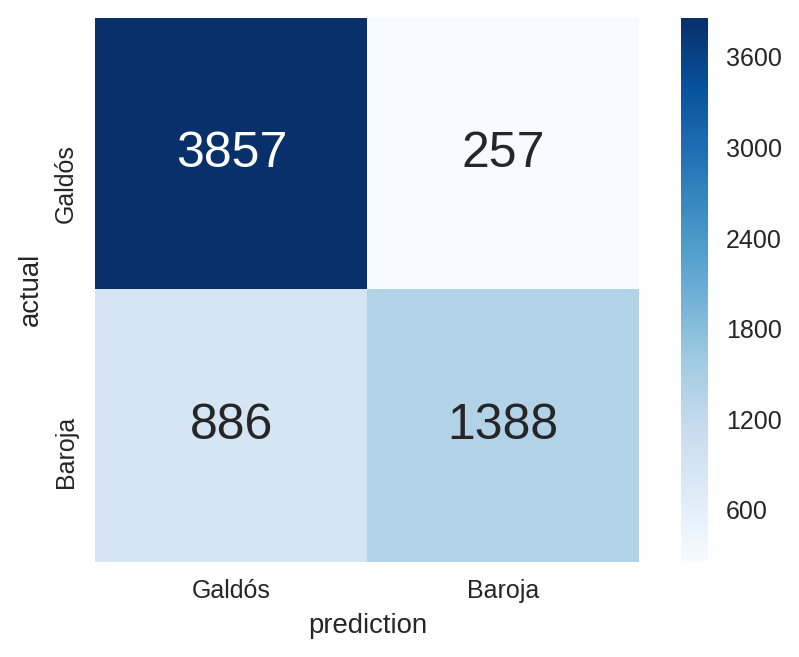

In [78]:
conf_plot_2(y_selected_test, y_pred)

In [79]:
print("Accuracy train")
print(rfc_2.score(process_selected_train.training_vectors, y_selected_train))
print("Accuracy test")
print(rfc_2.score(vectors_selected_test, y_selected_test))

Accuracy train
0.9925630186315955
Accuracy test
0.8210707576706324


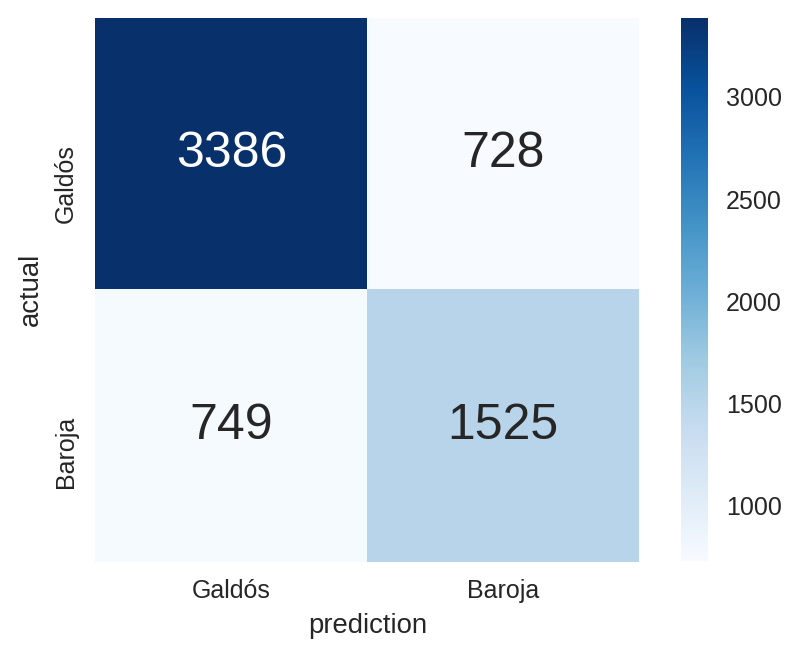

In [63]:
gaussNB = GaussianNB()
gaussNB.fit(process_selected_train.training_vectors, y_selected_train)
y_pred = gaussNB.predict(vectors_selected_test)
conf_plot_2(y_selected_test, y_pred)

In [65]:
print("Accuracy train")
print(gaussNB.score(process_selected_train.training_vectors, y_selected_train))
print("Accuracy test")
print(gaussNB.score(vectors_selected_test, y_selected_test))

Accuracy train
0.7721543760764052
Accuracy test
0.7687852222917971


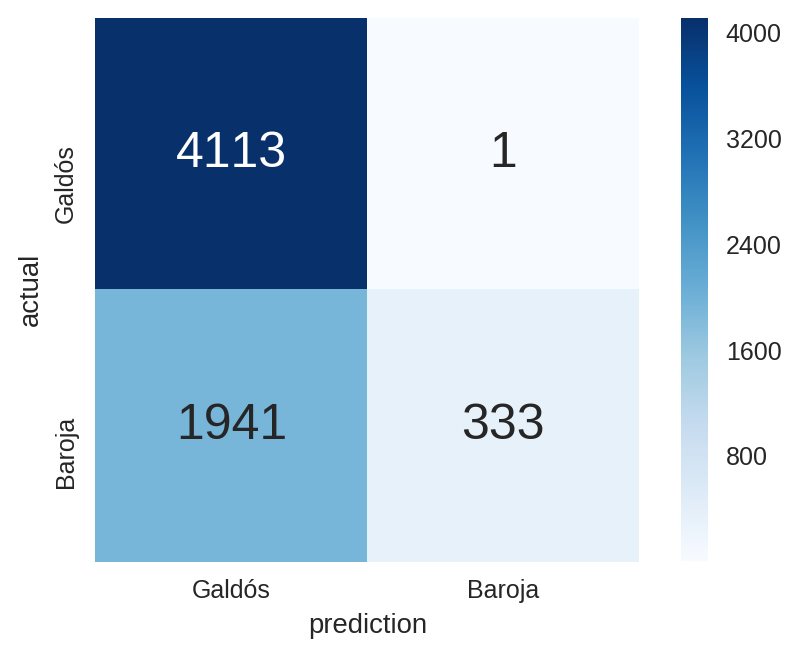

In [73]:
svc_2 = SVC()
svc_2.fit(process_selected_train.training_vectors, y_selected_train)
y_pred = svc_2.predict(vectors_selected_test)
conf_plot_2(y_selected_test, y_pred)

In [74]:
print("Accuracy train")
print(gaussNB.score(process_selected_train.training_vectors, y_selected_train))
print("Accuracy test")
print(gaussNB.score(vectors_selected_test, y_selected_test))

Accuracy train
0.37689838734930325
Accuracy test
0.2700375704445836


### Models with all authors and 30 components

In [69]:
process_all_train = vectorization_reduction(all_train, stop, vec="tfidf", dim_red="LSA", 
                                            n_comp=30, ngram_min=1, ngram_max=3, max_freq=0.3)
vectors_all_test = process_all_train.model.transform(process_all_train.vectorizer.transform(all_test))

In [35]:
param_grid = {'max_depth': [120], 'max_leaf_nodes':[1000]}
grid_estimator(RandomForestClassifier(), param_grid, process_all_train.training_vectors, 
               y_train, vectors_all_test, y_test, multiclass=True)

Accuracy training: 0.6633757615317668
Accuracy test: 0.6120961601218319
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=120, max_features='auto', max_leaf_nodes=1000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [60]:
rfc_all = RandomForestClassifier(max_depth = 120, max_leaf_nodes = 1000)
rfc_all.fit(process_all_train.training_vectors, y_train)
y_pred_all = rfc_all.predict(vectors_all_test)

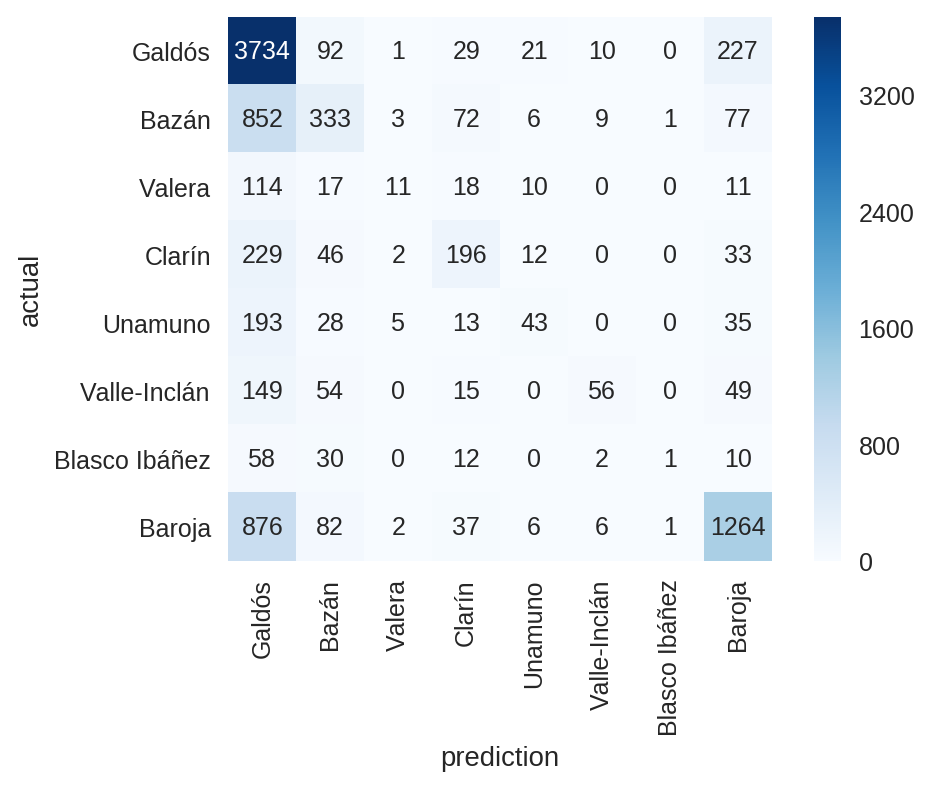

In [61]:
conf_plot_all(y_test, y_pred_all)

with Naive Bayes

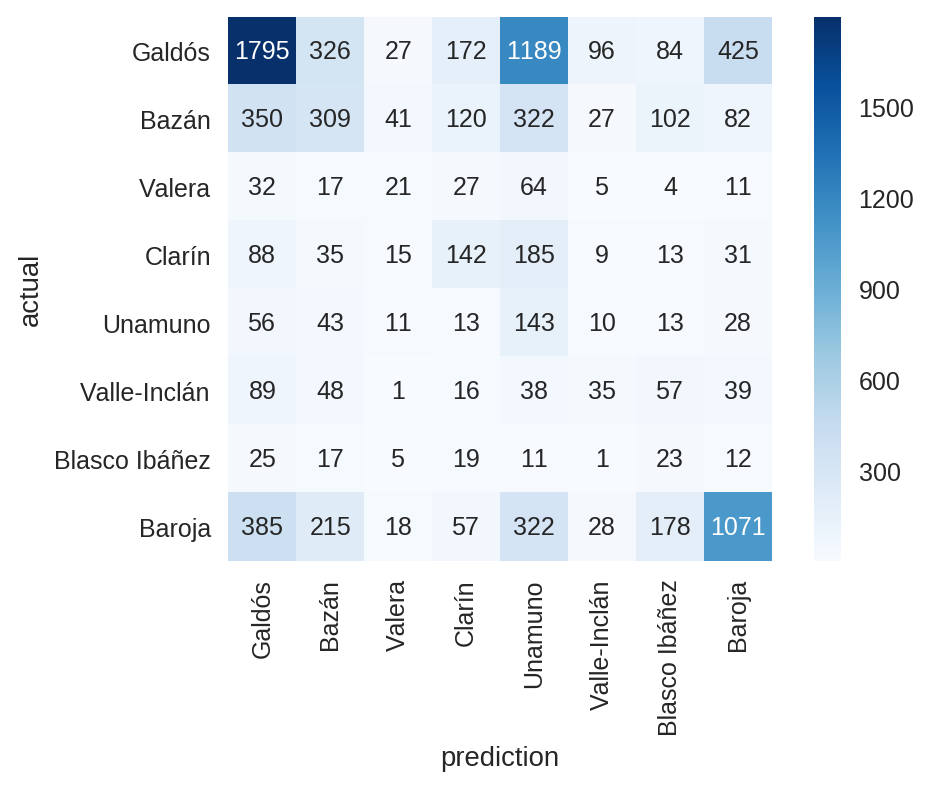

In [66]:
gaussNB = GaussianNB()
gaussNB.fit(process_all_train.training_vectors, y_train)
y_pred_all = gaussNB.predict(vectors_all_test)
conf_plot_all(y_test, y_pred_all)

In [67]:
print("Accuracy train")
print(gaussNB.score(process_all_train.training_vectors, y_train))
print("Accuracy test")
print(gaussNB.score(vectors_all_test, y_test))

Accuracy train
0.4018983899042646
Accuracy test
0.38496682258239967


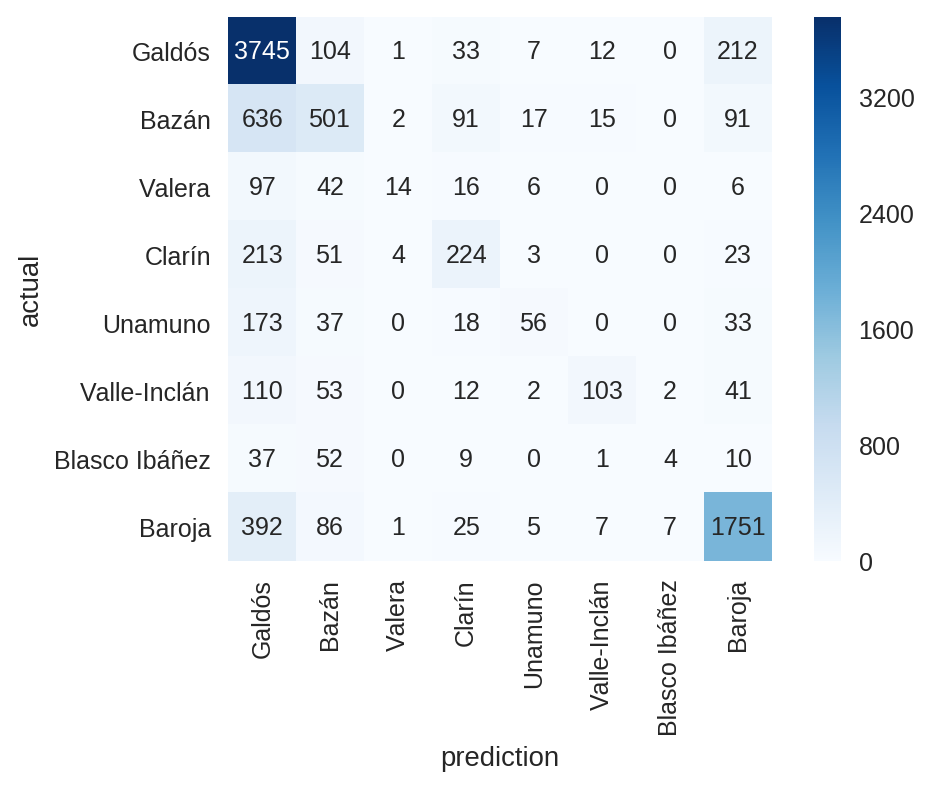

In [70]:
svc_all = SVC(C=100, gamma=1, kernel='rbf')
svc_all.fit(process_all_train.training_vectors, y_train)
y_pred_all = svc_all.predict(vectors_all_test)
conf_plot_all(y_test, y_pred_all)

In [71]:
print("Accuracy train")
print(svc_all.score(process_all_train.training_vectors, y_train))
print("Accuracy test")
print(svc_all.score(vectors_all_test, y_test))

Accuracy train
0.704226501305483
Accuracy test
0.6959643206787773
